## Cross-Sectional Stat-Arb (Residual Mean Reversion)

### [What this code does and why]

Idea / hypothesis
Markets move together because of shared risk factors (broad market, sector rotations, etc.). After removing
those common drivers, the remaining “idiosyncratic” part of a stock’s return can exhibit short-horizon
mean reversion due to liquidity provision, microstructure effects, and short-term overreaction.
This script tests that hypothesis in a realistic, portfolio-level way.

What we do (high level)
1) Pull daily price/volume data for a liquid equity universe (stocks) and a set of tradable factors
   (SPY + sector ETFs).
2) Estimate rolling factor exposures (betas) for each stock using only past data.
3) Compute daily residual returns:
\begin{equation}
\mathrm{residual}[t] = \mathrm{stock}_\mathrm{return}[t] − (\alpha[t−1] + \beta[t−1] \times \mathrm{factor}_\mathrm{returns}[t])
\end{equation}
   (the one-day lag prevents lookahead).
4) Build a cross-sectional mean-reversion signal from those residuals:
   long stocks with unusually negative residuals, short those with unusually positive residuals.
5) Construct a daily long/short portfolio and explicitly neutralize it:
   we project weights to be ~zero exposure to (a) dollars and (b) the factor set,
   so performance is not just “hidden market beta” or sector bets.
6) Apply risk controls: gross leverage target, position caps, and volatility targeting.
7) Backtest gross and net:
   - Gross PnL uses lagged weights * next-day returns (close-to-close convention).
   - Net PnL subtracts realistic frictions: linear bps costs plus an ADV-scaled impact proxy.
   We also record turnover to quantify how trading intensity affects net performance.

How to read the plots/results
- Equity Curve (Gross vs Net):
  Gross shows the raw edge; Net shows what survives after costs/impact.
  A large gap indicates the strategy is highly turnover-sensitive.
- Drawdown (Net):
  Highlights worst peak-to-trough loss; useful for judging risk beyond Sharpe.
- Rolling Sharpe (Net, 6M):
  Shows time-variation in performance; stat-arb edges are often regime-dependent.
- Market Exposure (SPY exposure over time):
  Should hover near 0 if neutrality is working; this helps argue the returns are not directional.
- Turnover:
  High turnover is common in short-horizon stat-arb; it must be justified by net performance.

Key takeaway
If the strategy remains profitable net of costs while maintaining near-zero factor exposures,
that supports the claim that we’re capturing a cross-sectional, idiosyncratic mean-reversion effect
rather than a disguised factor bet. If net performance collapses, the result is still valuable:
it indicates the signal is too weak once realistic trading frictions are included, pointing to
needed improvements (stronger signal, better universe filtering, smarter execution/cost model,
or slower rebalancing).


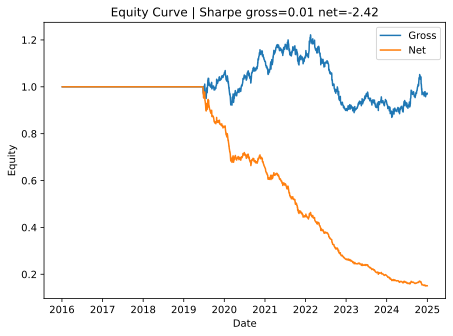

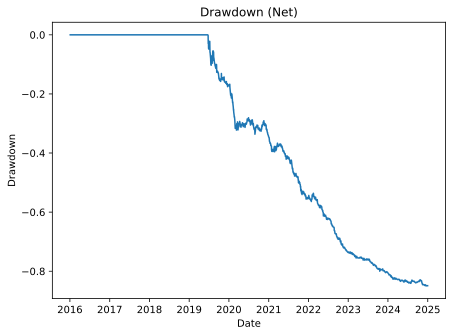

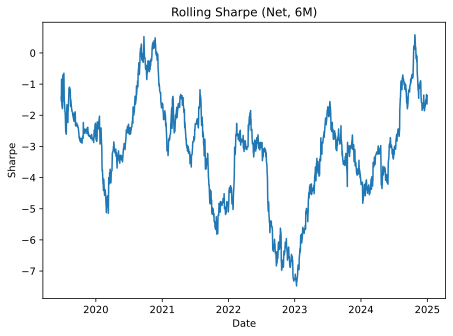

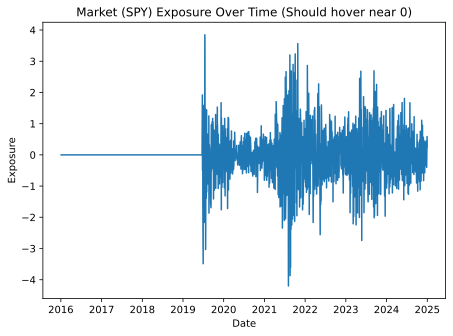

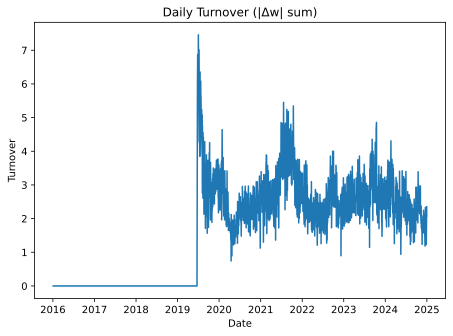

In [ ]:
# If needed:
# !pip -q install yfinance statsmodels scikit-learn pyarrow matplotlib tqdm

import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg'
# ------------------------
# Config
# ------------------------
start, end = "2016-01-01", "2025-01-01"
tickers = [
    "AAPL","MSFT","AMZN","GOOGL","META","NVDA","TSLA","JPM","XOM","JNJ",
    "V","MA","UNH","PG","HD","AVGO","COST","ABBV","LLY","KO",
    "PEP","CVX","BAC","WMT","MRK","CSCO","ADBE","CRM","NFLX","INTC",
]
factors = ["SPY","XLF","XLK","XLE","XLV","XLY","XLP","XLI","XLU","XLRE","XLB","XLC"]

beta_lookback, min_obs = 252, 200
q = 0.10                       # 10% long / 10% short
gross_leverage = 1.0
max_abs_w = 0.05
cost_bps = 5.0                 # linear cost per $ traded
impact_coef = 0.10             # impact proxy coefficient
adv_lookback = 20
zclip = 5.0
vol_target_annual = 0.10
vol_lookback = 60

# ------------------------
# Helpers
# ------------------------
def download_close_vol(tickers):
    raw = yf.download(tickers, start=start, end=end, auto_adjust=True, progress=False, group_by="column", threads=True)
    if isinstance(raw.columns, pd.MultiIndex):
        close = raw["Close"].copy()
        vol = raw["Volume"].copy()
    else:
        close = raw[["Close"]].rename(columns={"Close": tickers[0]})
        vol = raw[["Volume"]].rename(columns={"Volume": tickers[0]})
    close = close.sort_index().dropna(axis=1, how="all").astype(float)
    vol = vol.reindex(close.index)[close.columns].astype(float)
    return close, vol

def zscore(x: pd.Series) -> pd.Series:
    x = x.astype(float)
    sd = x.std(ddof=0)
    if not np.isfinite(sd) or sd == 0:
        return x * 0.0
    return (x - x.mean()) / sd

def project_neutral(w: pd.Series, C: pd.DataFrame) -> pd.Series:
    w = w.reindex(C.index).fillna(0.0).astype(float)
    Cn = C.fillna(0.0).astype(float)
    a = np.linalg.pinv((Cn.T @ Cn).values) @ (Cn.T @ w).values
    w2 = w - (Cn @ a)
    return w2.astype(float)

def scale_gross(w: pd.Series, target: float) -> pd.Series:
    g = float(np.nansum(np.abs(w.values)))
    return (w * (target / g)) if g > 0 else w * 0.0

def equity_curve(r: pd.Series) -> pd.Series:
    return (1.0 + r.fillna(0.0)).cumprod()

def sharpe(r: pd.Series) -> float:
    r = r.dropna()
    sd = r.std(ddof=0)
    return float(np.sqrt(252.0) * r.mean() / sd) if sd > 0 else np.nan

# ------------------------
# Pull data
# ------------------------
close_s, vol_s = download_close_vol(tickers)
close_f, vol_f = download_close_vol(factors)

rets_s = close_s.pct_change().replace([np.inf, -np.inf], np.nan)
rets_f = close_f.pct_change().replace([np.inf, -np.inf], np.nan)

idx = rets_s.index.intersection(rets_f.index)
rets_s, rets_f = rets_s.loc[idx], rets_f.loc[idx]

dollar_vol = (close_s * vol_s).reindex(idx)
adv = dollar_vol.rolling(adv_lookback, min_periods=max(5, adv_lookback//4)).mean()

# ------------------------
# Rolling betas: per stock vs factors
# ------------------------
Xfull = sm.add_constant(rets_f)   # const + factors
alpha = pd.DataFrame(index=idx, columns=rets_s.columns, dtype=float)
betas = {f: pd.DataFrame(index=idx, columns=rets_s.columns, dtype=float) for f in rets_f.columns}

for tkr in rets_s.columns:
    df = pd.concat([rets_s[tkr], Xfull], axis=1).dropna()
    if df.shape[0] < min_obs:
        continue
    y = df.iloc[:, 0]
    X = df.iloc[:, 1:]
    res = RollingOLS(y, X, window=beta_lookback, min_nobs=min_obs).fit()
    params = res.params
    alpha.loc[params.index, tkr] = params["const"]
    for f in rets_f.columns:
        betas[f].loc[params.index, tkr] = params[f]

# ------------------------
# Residuals (NO lookahead): use t-1 params to predict t return
# ------------------------
pred = alpha.shift(1)
for f in rets_f.columns:
    pred = pred.add(betas[f].shift(1).mul(rets_f[f], axis=0), fill_value=np.nan)

resid = rets_s - pred

# Signal = -zscore(resid) cross-sectionally each day
sig = pd.DataFrame(index=idx, columns=rets_s.columns, dtype=float)
for dt in idx:
    s = resid.loc[dt].dropna()
    if s.empty:
        continue
    z = zscore(s).clip(-zclip, zclip)
    sig.loc[dt, z.index] = (-z)

# ------------------------
# Build daily weights: quantile L/S then project to dollar+factor neutral
# ------------------------
W = pd.DataFrame(index=idx, columns=rets_s.columns, dtype=float)

for dt in idx:
    srow = sig.loc[dt].dropna()
    if srow.empty:
        W.loc[dt] = 0.0
        continue

    n = len(srow)
    k = max(1, int(np.floor(q * n)))
    longs = srow.nlargest(k).index
    shorts = srow.nsmallest(k).index

    w = pd.Series(0.0, index=rets_s.columns)
    w.loc[longs] =  1.0 / k
    w.loc[shorts] = -1.0 / k

    # constraints matrix C = [ones, beta_SPY, beta_XLK, ...]
    C = pd.DataFrame(index=rets_s.columns)
    C["ones"] = 1.0
    for f in rets_f.columns:
        C[f] = betas[f].reindex(index=[dt], columns=rets_s.columns).iloc[0]

    w = project_neutral(w, C)
    w = w.clip(-max_abs_w, max_abs_w)
    w = scale_gross(w, gross_leverage)
    W.loc[dt] = w

# Vol targeting
port_gross = (W.shift(1) * rets_s.fillna(0.0)).sum(axis=1)
roll_vol = port_gross.rolling(vol_lookback, min_periods=max(10, vol_lookback//3)).std(ddof=0) * np.sqrt(252.0)
scale = (vol_target_annual / roll_vol).replace([np.inf, -np.inf], np.nan).clip(upper=5.0)
W = W.mul(scale, axis=0).fillna(0.0)

# ------------------------
# Costs and PnL
# ------------------------
dw = W.diff().abs().fillna(0.0)
linear_cost = (cost_bps / 1e4) * dw.sum(axis=1)
impact_cost = impact_coef * (dw.div(adv.replace(0, np.nan))).replace([np.inf, -np.inf], np.nan).fillna(0.0).sum(axis=1)
costs = (linear_cost + impact_cost).fillna(0.0)

gross = (W.shift(1) * rets_s.fillna(0.0)).sum(axis=1)
net = gross - costs
turnover = dw.sum(axis=1)

# ------------------------
# PLOTS
# ------------------------
eq_g = equity_curve(gross)
eq_n = equity_curve(net)

plt.figure()
plt.plot(eq_g.index, eq_g.values, label="Gross")
plt.plot(eq_n.index, eq_n.values, label="Net")
plt.title(f"Equity Curve | Sharpe gross={sharpe(gross):.2f} net={sharpe(net):.2f}")
plt.xlabel("Date"); plt.ylabel("Equity")
plt.legend()
plt.tight_layout()

# Drawdown (net)
peak = eq_n.cummax()
dd = eq_n / peak - 1.0
plt.figure()
plt.plot(dd.index, dd.values)
plt.title("Drawdown (Net)")
plt.xlabel("Date"); plt.ylabel("Drawdown")
plt.tight_layout()

# Rolling Sharpe (net)
window = 126
roll_sh = (net.rolling(window).mean() / net.rolling(window).std(ddof=0)) * np.sqrt(252.0)
plt.figure()
plt.plot(roll_sh.index, roll_sh.values)
plt.title("Rolling Sharpe (Net, 6M)")
plt.xlabel("Date"); plt.ylabel("Sharpe")
plt.tight_layout()

# Factor exposure over time (should be ~0 after projection)
# exposure_t = sum_i w_i * beta_i
expo = pd.DataFrame(index=idx, columns=rets_f.columns, dtype=float)
for f in rets_f.columns:
    expo[f] = (W * betas[f].reindex(W.index)).sum(axis=1)

plt.figure()
plt.plot(expo.index, expo["SPY"].values)
plt.title("Market (SPY) Exposure Over Time (Should hover near 0)")
plt.xlabel("Date"); plt.ylabel("Exposure")
plt.tight_layout()

# Turnover
plt.figure()
plt.plot(turnover.index, turnover.values)
plt.title("Daily Turnover (|Δw| sum)")
plt.xlabel("Date"); plt.ylabel("Turnover")
plt.tight_layout()

plt.show()